In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import sys
sys.path.append("../../")
from src.util import operators
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_nonlinear as compute_exp_val_nonlinear
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_linear as compute_exp_val_linear
from src.util import bath_correlation_function
from src.util import debye_spectral_density  
from src.homps import homps
from src.util import operators

In [3]:
# Parameters for the spin-boson model
epsilon = 2.0
delta = -2.0
# Parameters for the Debye spectral density
beta = 50.0
T = 1/beta
gamma = 5.0
eta = 0.5
# operators
sigma_x, sigma_z, eye = operators.generate_physical_operators()
L = sigma_z
h = operators.generate_spin_boson_hamiltonian(delta=delta, epsilon=epsilon)
# time window
duration = 30

# Convergence of the BCF

In [4]:
N_steps = 1000
taus = np.linspace(0, duration, N_steps)
N_terms = [13, 100]
alphas = np.empty((len(N_terms), N_steps), dtype=complex)
for i, N in enumerate(N_terms):
    g, w = debye_spectral_density.get_debye_coefficients(N, T, gamma, eta)
    alphas[i, :] = bath_correlation_function.alpha(taus, g, w)

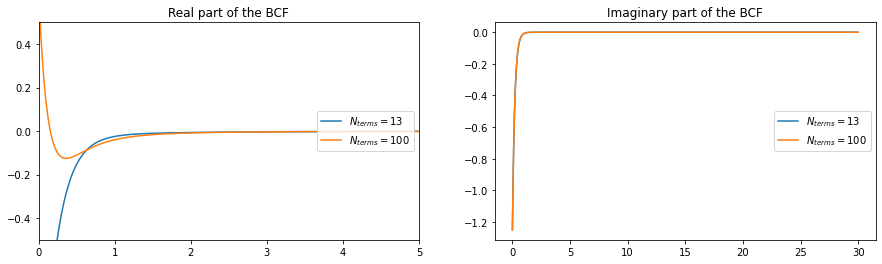

In [5]:
figure, axarray = plt.subplots(1, 2, figsize=(15, 4))
for i, N in enumerate(N_terms):
    axarray[0].plot(taus, np.real(alphas[i, :]), label="$N_{terms} = "+str(N)+"$")
    axarray[1].plot(taus, np.imag(alphas[i, :]), label="$N_{terms} = "+str(N)+"$")
axarray[0].legend(loc="right")
axarray[0].set_title("Real part of the BCF")
axarray[0].set_xlim(0, 5)
axarray[0].set_ylim(-0.5, 0.5)
axarray[1].legend(loc="right")
axarray[1].set_title("Imaginary part of the BCF")
plt.show()

# HOMPS

In [6]:
N_terms = 13

In [7]:
g, w = debye_spectral_density.get_debye_coefficients(N_terms, T, gamma, eta)

In [8]:
N_steps = 1000
N_trunc = 9

In [9]:
chimax = 3
eps = 0
N_krylov = 5

Without noise:


/home/benjamin/Documents/Uni/Informatik Bachelorarbeit/code/test/homps/../../src/util/krylov.py:84: RuntimeWarning: H[1, 0] ~= 0 encountered during Arnoldi iteration.
  warnings.warn(
/home/benjamin/Documents/Uni/Informatik Bachelorarbeit/code/test/homps/../../src/util/krylov.py:84: RuntimeWarning: H[1, 0] ~= 0 encountered during Arnoldi iteration.
  warnings.warn(


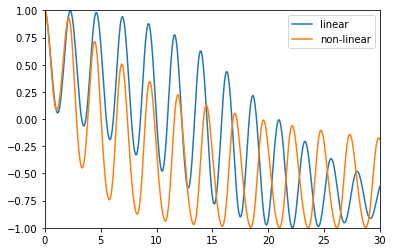

In [40]:
print("Without noise:")
hierarchy = homps.HOMPS_TDVP(g, w, h, L, duration, N_steps, N_trunc, linear=True, use_noise=False, chimax=chimax, epsilon=eps, N_krylov=N_krylov)
psis = hierarchy.compute_realizations(1)
sigma_zs = compute_exp_val_linear(psis, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "-", label="linear")

hierarchy = homps.HOMPS_TDVP(g, w, h, L, duration, N_steps, N_trunc, linear=False, use_noise=False, chimax=chimax, epsilon=eps, N_krylov=N_krylov)
psis = hierarchy.compute_realizations(1)
sigma_zs = compute_exp_val_nonlinear(psis, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "-", label="non-linear")

plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.legend()
plt.show()

In [10]:
hierarchy = homps.HOMPS_TDVP(g, w, h, L, duration, N_steps, N_trunc, linear=False, use_noise=True, chimax=chimax, epsilon=eps, N_krylov=N_krylov)

In [11]:
psis_100 = hierarchy.compute_realizations(N_samples=100, progressBar=tqdm)

  0%|          | 0/100 [00:00<?, ?it/s]

/home/benjamin/Documents/Uni/Informatik Bachelorarbeit/code/test/homps/../../src/util/krylov.py:84: RuntimeWarning: H[1, 0] ~= 0 encountered during Arnoldi iteration.
  warnings.warn(


Takes ~5:00 minutes per realization for chi_max = 10,
and ~2:20 minutes per realization for chi_max = 3 ...

In [12]:
sigma_zs_100 = compute_exp_val_nonlinear(psis_100, sigma_z)

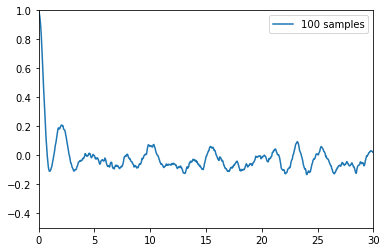

In [14]:
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_100, label="100 samples")
plt.legend()
plt.ylim(-0.5, 1)
plt.xlim(0, duration)
plt.show()

# Performance analysis